# New York City Taxi Trip Duration

https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data

* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

## dataset

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from math import sin, cos, sqrt, atan2, radians

# 학습 데이터와 검증 데이터 나눠주기
from sklearn.model_selection import train_test_split

# 결정트리 모델을 구현한 라이브러리
from sklearn.tree import DecisionTreeRegressor
# 랜덤포레스트 모델을 구현한 라이브러리
from sklearn.ensemble import RandomForestRegressor
# 부스팅을 이용한 트리모델 구현 라이브러리
from sklearn.ensemble import GradientBoostingRegressor
# 엑스트라트리모델을 구현한 라이브러리
from sklearn.ensemble import ExtraTreesRegressor
# xgboost(GBT의 병렬학습을 구현한) 라이브러리
import xgboost as xgb
# lightgbm 라이브러리
import lightgbm as lgbm

/Users/kwonsojung/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import glob


glob.glob("data/taxi-trip/*")

['data/taxi-trip/test.zip',
 'data/taxi-trip/sample_submission.zip',
 'data/taxi-trip/train.zip']

In [3]:
train = pd.read_csv("data/taxi-trip/train.zip")
print(train.shape)
train.head()

(1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
test = pd.read_csv("data/taxi-trip/test.zip")
print(test.shape)
test.head()

(625134, 9)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [5]:
# train과 test 컬럼 비교
set(train.columns) - set(test.columns)

{'dropoff_datetime', 'trip_duration'}

In [6]:
# train에서 dropoff_datetime drop해주기
train = train.drop(["dropoff_datetime"], axis=1)
train.shape

(1458644, 10)

In [7]:
# sub
sub = pd.read_csv("data/taxi-trip/sample_submission.zip")
print(sub.shape)
sub.head()

(625134, 2)


,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


## EDA

In [8]:
# info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   passenger_count     1458644 non-null  int64  
 4   pickup_longitude    1458644 non-null  float64
 5   pickup_latitude     1458644 non-null  float64
 6   dropoff_longitude   1458644 non-null  float64
 7   dropoff_latitude    1458644 non-null  float64
 8   store_and_fwd_flag  1458644 non-null  object 
 9   trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 111.3+ MB


In [9]:
# info
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [10]:
# 결측치 확인
display(train.isnull().sum().sum())
display(test.isnull().sum().sum())

0

0

In [11]:
# 각 컬럼 고유값 확인
for col in train.columns:
    print(col, ":", end="")
    print(train[col].unique(), end="\n\n")

id :['id2875421' 'id2377394' 'id3858529' ... 'id2304944' 'id2714485'
 'id1209952']

vendor_id :[2 1]

pickup_datetime :['2016-03-14 17:24:55' '2016-06-12 00:43:35' '2016-01-19 11:35:24' ...
 '2016-01-10 07:35:15' '2016-04-22 06:57:41' '2016-01-05 15:56:26']

passenger_count :[1 6 4 2 3 5 0 7 9 8]

pickup_longitude :[-73.98215485 -73.98041534 -73.97902679 ... -73.84746552 -73.89477539
 -73.84131622]

pickup_latitude :[40.76793671 40.73856354 40.7639389  ... 40.69665146 40.83586502
 40.82304382]

dropoff_longitude :[-73.96463013 -73.9994812  -74.00533295 ... -73.85946655 -74.04266357
 -73.76462555]

dropoff_latitude :[40.76560211 40.73115158 40.71008682 ... 40.65151978 40.64244461
 40.62860489]

store_and_fwd_flag :['N' 'Y']

trip_duration :[  455   663  2124 ... 11513 72504  6124]



In [12]:
# nnuique
train.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

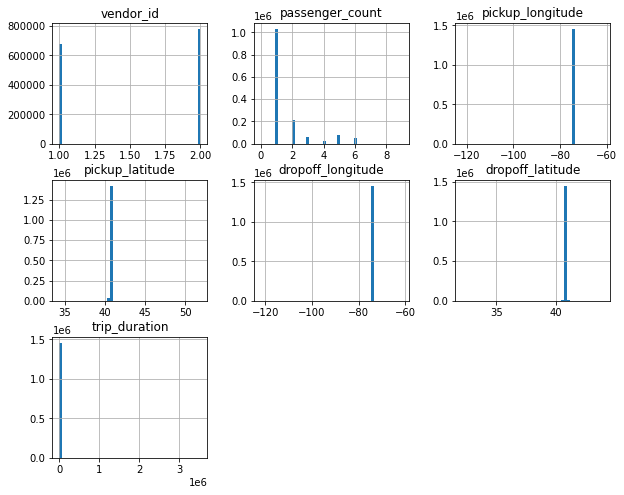

In [13]:
# hist
_ = train.hist(bins=50, figsize=(10,8))

<AxesSubplot:>

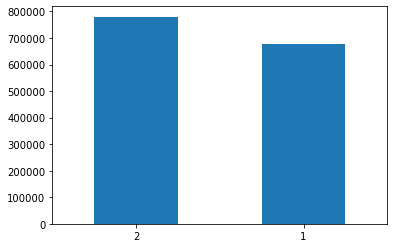

In [14]:
# vendor id 각 빈도수 시각화
train["vendor_id"].value_counts().plot(kind="bar", rot=0)

### 전처리

In [15]:
# # "store and fwd flag" int로 타입 변경
train["store_and_fwd_flag"] = train["store_and_fwd_flag"].replace("Y", 1)
train["store_and_fwd_flag"] = train["store_and_fwd_flag"].replace("N", 0)
train["store_and_fwd_flag"].value_counts()

0    1450599
1       8045
Name: store_and_fwd_flag, dtype: int64

In [17]:
# "store and fwd flag" int로 타입 변경
test["store_and_fwd_flag"] = test["store_and_fwd_flag"].replace("Y", 1)
test["store_and_fwd_flag"] = test["store_and_fwd_flag"].replace("N", 0)
test["store_and_fwd_flag"].value_counts()

0    621704
1      3430
Name: store_and_fwd_flag, dtype: int64

In [18]:
# pickupdatetime -> datetime 타입으로 변경
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])
train["pickup_datetime"]

0         2016-03-14 17:24:55
1         2016-06-12 00:43:35
2         2016-01-19 11:35:24
3         2016-04-06 19:32:31
4         2016-03-26 13:30:55
                  ...        
1458639   2016-04-08 13:31:04
1458640   2016-01-10 07:35:15
1458641   2016-04-22 06:57:41
1458642   2016-01-05 15:56:26
1458643   2016-04-05 14:44:25
Name: pickup_datetime, Length: 1458644, dtype: datetime64[ns]

In [19]:
# 날짜 파생변수 생성
train["date"] = train["pickup_datetime"].dt.date
train["dayofweek"] = train["pickup_datetime"].dt.dayofweek
train["day"] = train["pickup_datetime"].dt.day
train["hour"] = train["pickup_datetime"].dt.hour

In [20]:
train.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,dayofweek,day,hour
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.96463,40.765602,0,455,2016-03-14,0,14,17


In [21]:
# pickupdatetime -> datetime 타입으로 변경
test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"])
test["pickup_datetime"]

0        2016-06-30 23:59:58
1        2016-06-30 23:59:53
2        2016-06-30 23:59:47
3        2016-06-30 23:59:41
4        2016-06-30 23:59:33
                 ...        
625129   2016-01-01 00:02:52
625130   2016-01-01 00:01:52
625131   2016-01-01 00:01:24
625132   2016-01-01 00:00:28
625133   2016-01-01 00:00:22
Name: pickup_datetime, Length: 625134, dtype: datetime64[ns]

In [22]:
# 날짜 파생변수 생성
test["date"] = test["pickup_datetime"].dt.date
test["dayofweek"] = test["pickup_datetime"].dt.dayofweek
test["day"] = test["pickup_datetime"].dt.day
test["hour"] = test["pickup_datetime"].dt.hour

In [23]:
train.shape, test.shape

((1458644, 14), (625134, 13))

Text(0.5, 1.0, 'Pick Hours Distribution')

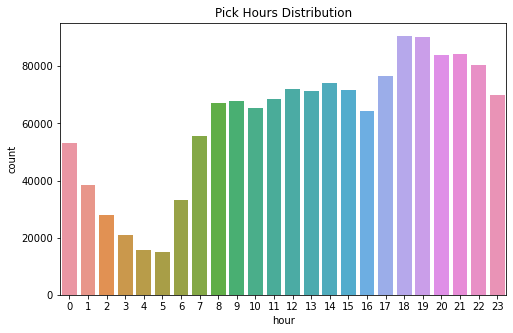

In [24]:
# 시간대별 빈도수 시각화
plt.figure(figsize=(8,5))
sns.countplot(x=train["hour"]).set_title("Pick Hours Distribution")

Text(0.5, 1.0, 'Distribution of Pickups over time')

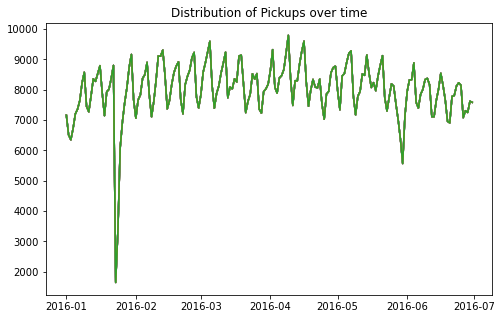

In [25]:
# 전체 pickup 시간대 분포
plt.figure(figsize=(8,5))
plt.plot(train.groupby("date").count())
plt.title("Distribution of Pickups over time")

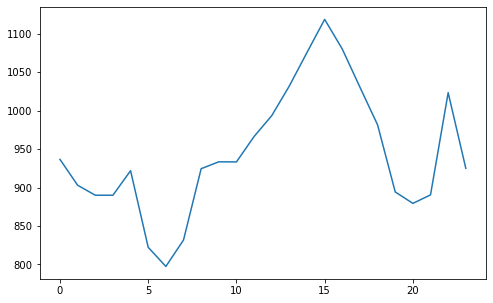

In [26]:
# 시간대별로 trip 기간
avg_duration_hour = train.groupby(["hour"])
plt.figure(figsize=(8,5))
plt.plot(train.groupby(["hour"])["trip_duration"].mean())

/Users/kwonsojung/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='dayofweek', ylabel='count'>

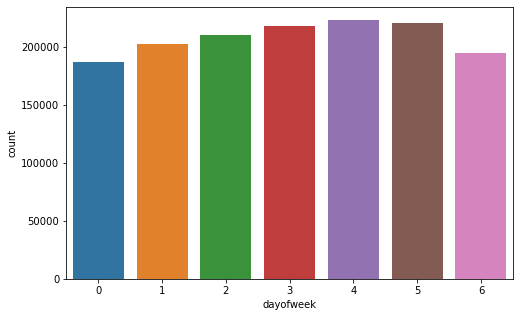

In [27]:
# 요일별 pickup 배분 시간
plt.figure(figsize=(8,5))
sns.countplot(train["dayofweek"])

In [28]:
# 위도 기술통계
train["pickup_latitude"].describe()

count    1.458644e+06
mean     4.075092e+01
std      3.288119e-02
min      3.435970e+01
25%      4.073735e+01
50%      4.075410e+01
75%      4.076836e+01
max      5.188108e+01
Name: pickup_latitude, dtype: float64

In [29]:
# 범위 벗어나는 위도 확인 
drop1 = train[train["pickup_latitude"]< -90]
drop2 = train[train["pickup_latitude"]> 90]
display(drop1)
display(drop2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,dayofweek,day,hour


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,dayofweek,day,hour


In [30]:
# 경도 기술통계
train["pickup_longitude"].describe()

count    1.458644e+06
mean    -7.397349e+01
std      7.090186e-02
min     -1.219333e+02
25%     -7.399187e+01
50%     -7.398174e+01
75%     -7.396733e+01
max     -6.133553e+01
Name: pickup_longitude, dtype: float64

In [31]:
# 범위 벗어나는 경도 확인
drop3 = train[train["pickup_longitude"]< -180]
drop4 = train[train["pickup_longitude"]> 180]
display(drop3)
display(drop4)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,dayofweek,day,hour


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,dayofweek,day,hour


In [32]:
## 위도 경도 변수 소수점 이하 3자리까지 반올림
train['pickup_latitude']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude']=train['dropoff_longitude'].apply(lambda x:round(x,3))

In [33]:
train.shape

(1458644, 14)

In [34]:
# 위도 경도를 사용하여 거리 함수 만들기
def calculateDistance(row):
    R=6376.0 # 지구의 대략적인 반경(km)
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon -pickup_lon
    dlat = dropoff_lat -pickup_lat
    
    a=sin(dlat /2) **2 +cos(pickup_lat)*cos(dropoff_lat)*sin(dlon/2)**2
    c=2*atan2(sqrt(a), sqrt(1-a))
    distance=R*c
    return distance

In [35]:
train['trip_distance'] = train.apply(lambda row:calculateDistance(row), axis=1)
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,dayofweek,day,hour,trip_distance
0,id2875421,2,2016-03-14 17:24:55,1,-73.982,40.768,-73.965,40.766,0,455,2016-03-14,0,14,17,1.449976
1,id2377394,1,2016-06-12 00:43:35,1,-73.980,40.739,-73.999,40.731,0,663,2016-06-12,6,12,0,1.832859
2,id3858529,2,2016-01-19 11:35:24,1,-73.979,40.764,-74.005,40.710,0,2124,2016-01-19,1,19,11,6.396656
3,id3504673,2,2016-04-06 19:32:31,1,-74.010,40.720,-74.012,40.707,0,429,2016-04-06,2,6,19,1.456472
4,id2181028,2,2016-03-26 13:30:55,1,-73.973,40.793,-73.973,40.783,0,435,2016-03-26,5,26,13,1.112822


In [36]:
test['trip_distance'] = test.apply(lambda row:calculateDistance(row), axis=1)
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,date,dayofweek,day,hour,trip_distance
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,2016-06-30,3,30,23,2.748581
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,2016-06-30,3,30,23,2.761404
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,2016-06-30,3,30,23,1.307180
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,0,2016-06-30,3,30,23,5.273223
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0,2016-06-30,3,30,23,0.961596


In [37]:
# 상관계수
corr_train = train.corr()

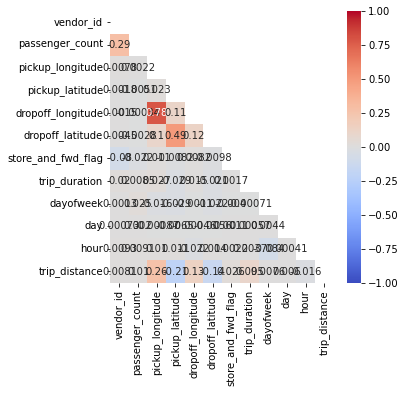

In [38]:
# 상관관계 시각화
mask = np.triu(np.ones_like(corr_train))
plt.figure(figsize=(5,5))
_ = sns.heatmap(corr_train, cmap="coolwarm", annot=True, mask=mask, vmax=1, vmin=-1)

In [39]:
corr_test = test.corr()

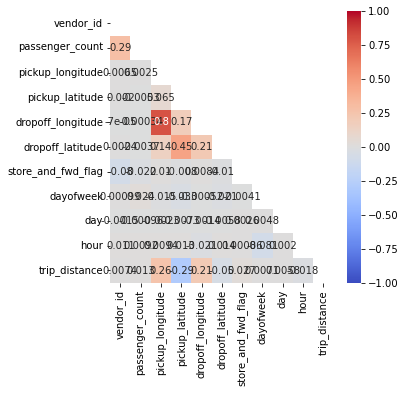

In [40]:
mask = np.triu(np.ones_like(corr_test))
plt.figure(figsize=(5,5))
_ = sns.heatmap(corr_test, cmap="coolwarm", annot=True, mask=mask, vmax=1, vmin=-1)

In [41]:
# 데이터 타입 확인
display(train.dtypes)
display(test.dtypes)

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
date                          object
dayofweek                      int64
day                            int64
hour                           int64
trip_distance                float64
dtype: object

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
date                          object
dayofweek                      int64
day                            int64
hour                           int64
trip_distance                float64
dtype: object

In [42]:
train.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
passenger_count            10
pickup_longitude          618
pickup_latitude           498
dropoff_longitude         923
dropoff_latitude          643
store_and_fwd_flag          2
trip_duration            7417
date                      182
dayofweek                   7
day                        31
hour                       24
trip_distance          455158
dtype: int64

In [43]:
train["date"] = train["date"].astype("category").cat.codes

In [44]:
train.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
date                           int16
dayofweek                      int64
day                            int64
hour                           int64
trip_distance                float64
dtype: object

In [45]:
test["date"] = test["date"].astype("category").cat.codes

In [46]:
test.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
date                           int16
dayofweek                      int64
day                            int64
hour                           int64
trip_distance                float64
dtype: object

In [48]:
# 필요없는 컬럼 제거
train = train.drop(["id", "pickup_datetime",
                    "pickup_longitude", "pickup_latitude",
                    "dropoff_longitude", "dropoff_latitude"],axis=1)

In [49]:
# 필요없는 컬럼 제거
test = test.drop(["id", "pickup_datetime",
                    "pickup_longitude", "pickup_latitude",
                    "dropoff_longitude", "dropoff_latitude"],axis=1)

In [50]:
train.shape, test.shape

((1458644, 9), (625134, 8))

## Modeling

In [51]:
#label_name
label_name = "trip_duration"
label_name

'trip_duration'

In [52]:
# feature_names
feature_names = train.columns.tolist()
feature_names.remove(label_name)

feature_names

['vendor_id',
 'passenger_count',
 'store_and_fwd_flag',
 'date',
 'dayofweek',
 'day',
 'hour',
 'trip_distance']

In [53]:
X = train.drop(columns=["trip_duration"])
y = train["trip_duration"]
display(X)
display(y)

,vendor_id,passenger_count,store_and_fwd_flag,date,dayofweek,day,hour,trip_distance
0,2,1,0,73,0,14,17,1.449976
1,1,1,0,163,6,12,0,1.832859
2,2,1,0,18,1,19,11,6.396656
3,2,1,0,96,2,6,19,1.456472
4,2,1,0,85,5,26,13,1.112822
...,...,...,...,...,...,...,...,...
1458639,2,4,0,98,4,8,13,1.283419
1458640,1,1,0,9,6,10,7,6.146926
1458641,2,1,0,112,4,22,6,7.874012
1458642,1,1,0,4,1,5,15,1.068070


0           455
1           663
2          2124
3           429
4           435
           ... 
1458639     778
1458640     655
1458641     764
1458642     373
1458643     198
Name: trip_duration, Length: 1458644, dtype: int64

In [54]:
# 학습데이터와 검증데이터 나누기
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size=0.9, random_state=42)

In [55]:
# score 함수 생성
def scoreModel(model, X_train, X_valid, y_train, y_valid):
    '''
        머신러닝 모델과 X_train, X_valid, y_train, y_valid 변수를 받아서
        모델명, 학습용 세트 정확도(R2 score), 테스트 세트 정확도(R2 score)를 출력하는 함수
    '''
    print("모델 : {}".format(model))
    print("학습용 세트 정확도: {:.3f}".format(model.score(X_train, y_train)))
    valid_score = model.score(X_valid, y_valid)
    print("검증 세트 정확도: {:.3f}".format(valid_score))
    return valid_score

### GBT

In [56]:
# 모델 생성
from sklearn.ensemble import GradientBoostingRegressor

model_gbt = GradientBoostingRegressor(random_state=42)
model_gbt

GradientBoostingRegressor(random_state=42)

In [57]:
# 모델을 학습시킵니다.
model_gbt.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [59]:
# 모델에 대한 점수 산출
score = scoreModel(model_gbt, X_train, X_valid, y_train, y_valid)

모델 : GradientBoostingRegressor(random_state=42)
학습용 세트 정확도: 0.229
검증 세트 정확도: 0.028


In [60]:
# 예측값 확인
prediction_gbt = model_gbt.predict(test)
prediction_gbt

array([ 765.08931285,  765.08931285,  411.40462574, ..., 1410.98443649,
       9148.83187402, 1347.34804263])

In [61]:
# sub 확인
sub["trip_duration"] = prediction_gbt
sub

,id,trip_duration
0,id3004672,765.089313
1,id3505355,765.089313
2,id1217141,411.404626
3,id2150126,1440.709645
4,id1598245,289.999881
...,...,...
625129,id3008929,466.423421
625130,id3700764,1352.967951
625131,id2568735,1410.984436
625132,id1384355,9148.831874


In [62]:
# 파일 저장
file_name = f"data/taxi-trip/sub_gbt_{score}.csv"
sub.to_csv(file_name , index=False)
pd.read_csv(file_name)

,id,trip_duration
0,id3004672,765.089313
1,id3505355,765.089313
2,id1217141,411.404626
3,id2150126,1440.709645
4,id1598245,289.999881
...,...,...
625129,id3008929,466.423421
625130,id3700764,1352.967951
625131,id2568735,1410.984436
625132,id1384355,9148.831874


### XGB

In [63]:
# xgboost 분류모델 생성
import xgboost as xgb

model_xgb = xgb.XGBRFRegressor(random_State=42, learning_rate=0.05, verbosity=0)
model_xgb

XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bytree=None, enable_categorical=False, gamma=None,
               gpu_id=None, importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_State=42,
               random_state=None, reg_alpha=None, scale_pos_weight=None,
               tree_method=None, validate_parameters=None, verbosity=0)

In [64]:
# 모델을 학습시킵니다.
model_xgb.fit(X_train, y_train)

/Users/kwonsojung/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, enable_categorical=False, gamma=0, gpu_id=-1,
               importance_type=None, interaction_constraints='',
               learning_rate=0.05, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=100,
               objective='reg:squarederror', predictor='auto', random_State=42,
               random_state=0, reg_alpha=0, scale_pos_weight=1,
               tree_method='exact', validate_parameters=1, verbosity=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

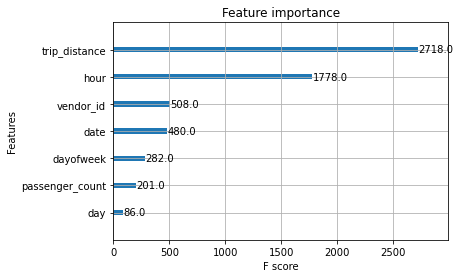

In [65]:
xgb.plot_importance(model_xgb)

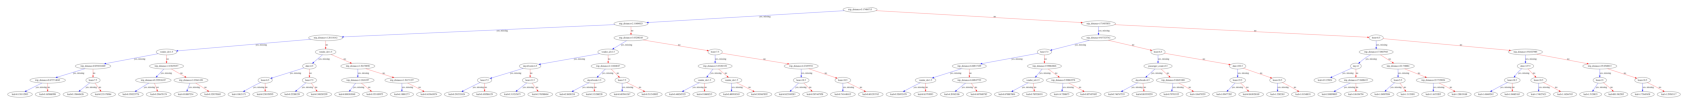

In [66]:
xgb.plot_tree(model_xgb, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(30, 20)

In [67]:
# 모델에 대한 점수를 산출합니다.
score = scoreModel(model_xgb, X_train, X_valid, y_train, y_valid)

모델 : XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, enable_categorical=False, gamma=0, gpu_id=-1,
               importance_type=None, interaction_constraints='',
               learning_rate=0.05, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=100,
               objective='reg:squarederror', predictor='auto', random_State=42,
               random_state=0, reg_alpha=0, scale_pos_weight=1,
               tree_method='exact', validate_parameters=1, verbosity=0)


/Users/kwonsojung/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


학습용 세트 정확도: -0.019
검증 세트 정확도: -0.074


/Users/kwonsojung/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [68]:
# 예측값을 확인합니다.
prediction_xgb = model_xgb.predict(test)
prediction_xgb

/Users/kwonsojung/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


array([  39.707333,   40.356903,   27.619211, ...,   66.144646,
       1024.7555  ,   70.87256 ], dtype=float32)

In [69]:
# sub
sub["trip_duration"] = prediction_xgb
sub

,id,trip_duration
0,id3004672,39.707333
1,id3505355,40.356903
2,id1217141,27.619211
3,id2150126,68.977219
4,id1598245,21.049330
...,...,...
625129,id3008929,17.046846
625130,id3700764,58.680824
625131,id2568735,66.144646
625132,id1384355,1024.755493


In [70]:
# 파일 저장
file_name = f"data/taxi-trip/sub_xgb_{score}.csv"
sub.to_csv(file_name , index=False)
pd.read_csv(file_name)

,id,trip_duration
0,id3004672,39.707333
1,id3505355,40.356903
2,id1217141,27.619211
3,id2150126,68.977220
4,id1598245,21.049330
...,...,...
625129,id3008929,17.046846
625130,id3700764,58.680824
625131,id2568735,66.144646
625132,id1384355,1024.755500


### LGBM

In [72]:
# 모델 생성
import lightgbm as lgbm

model_lgbm = lgbm.LGBMRegressor(learning_rate=0.01, max_depth = 3,
                                 random_state=42, n_estimators=1000)
model_lgbm

LGBMRegressor(learning_rate=0.01, max_depth=3, n_estimators=1000,
              random_state=42)

In [73]:
# 모델 학습
model_lgbm.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.01, max_depth=3, n_estimators=1000,
              random_state=42)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

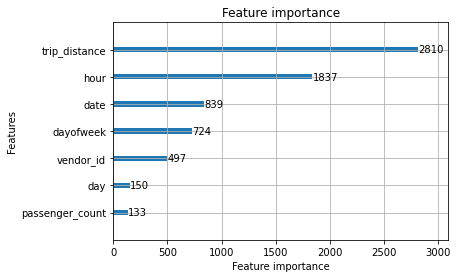

In [74]:
# feature 중요도 시각화
lgbm.plot_importance(model_lgbm)

<AxesSubplot:>

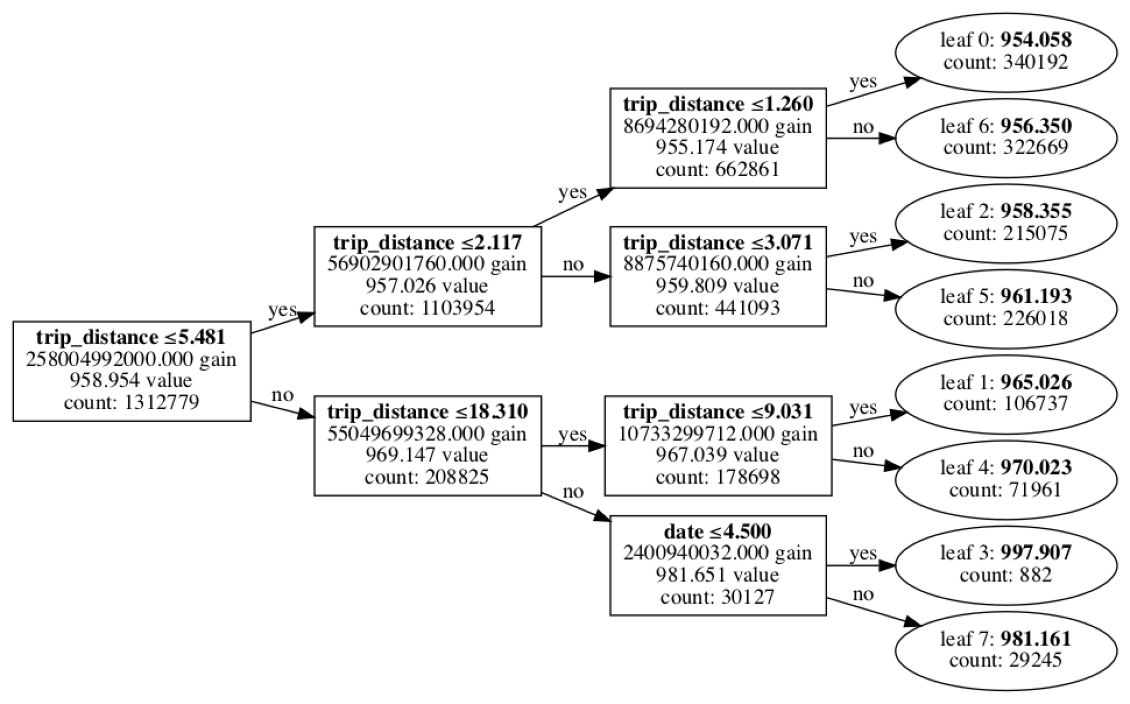

In [75]:
lgbm.plot_tree(model_lgbm, figsize=(20, 20), tree_index=0, 
               show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])

In [76]:
# 모델에 대한 score 산출
score = scoreModel(model_lgbm, X_train, X_valid, y_train, y_valid)

모델 : LGBMRegressor(learning_rate=0.01, max_depth=3, n_estimators=1000,
              random_state=42)
학습용 세트 정확도: 0.014
검증 세트 정확도: 0.029


In [77]:
# 예측값 확인
prediction_lgbm = model_lgbm.predict(test)
prediction_lgbm

array([  740.6409712 ,   755.55419341,   394.73054316, ...,
        1600.16651143, 12277.67488343,  1457.13142481])

In [78]:
# sub
sub["trip_duration"] = prediction_lgbm
sub

,id,trip_duration
0,id3004672,740.640971
1,id3505355,755.554193
2,id1217141,394.730543
3,id2150126,1383.753295
4,id1598245,284.691522
...,...,...
625129,id3008929,455.840153
625130,id3700764,1332.177212
625131,id2568735,1600.166511
625132,id1384355,12277.674883


In [79]:
# 파일 저장
file_name = f"data/taxi-trip/sub_lgbm_{score}.csv"
sub.to_csv(file_name , index=False)
pd.read_csv(file_name)

,id,trip_duration
0,id3004672,740.640971
1,id3505355,755.554193
2,id1217141,394.730543
3,id2150126,1383.753295
4,id1598245,284.691522
...,...,...
625129,id3008929,455.840153
625130,id3700764,1332.177212
625131,id2568735,1600.166511
625132,id1384355,12277.674883
